# (Kaggle) 房價預測
***
- 以下用房價預測資料
- 展示特徵篩選的作法
  - 相關係數過濾法
  - L1 嵌入法的寫作方式
- 使用擬合過的模型, 計算特徵重要性
- 對照原始特徵, 觀察特徵重要性較高的一半特徵, 搭配隨機森林對於測結果的影響
- 重組重要性最高的特徵作為新特徵

In [61]:
import warnings
warnings.filterwarnings('ignore')

# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso
from itertools import compress

data_path = 'data/'
df = pd.read_csv(data_path + 'house_train.csv')

train_Y = np.log1p(df['SalePrice'])
df = df.drop(['Id'] , axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


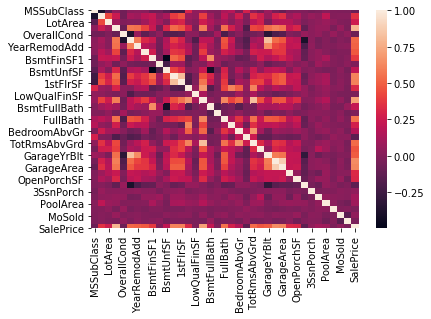

In [62]:
# 計算df整體相關係數, 並繪製成熱圖
corr = df.corr()
sns.heatmap(corr)
plt.show()

In [63]:
# 記得刪除 SalePrice
df = df.drop(['SalePrice'] , axis=1)

#只取 int64, float64 兩種數值型欄位, 存於 num_features 中
num_features = []
for dtype, feature in zip(df.dtypes, df.columns):
    if dtype == 'float64' or dtype == 'int64':
        num_features.append(feature)

# 削減文字型欄位, 只剩數值型欄位
df = df[num_features]
df = df.fillna(-1)
MMEncoder = MinMaxScaler()
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


In [64]:
# 篩選相關係數大於 0.1 或小於 -0.1 的特徵
high_list = list(corr[(corr['SalePrice']>0.1) | (corr['SalePrice']<-0.1)].index)
high_list.pop(-1)

L1_Reg = Lasso(alpha=0.001)
train_X = MMEncoder.fit_transform(df)
L1_Reg.fit(train_X, train_Y)
L1_Reg.coef_

L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
df.columns[L1_mask]
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
L1_list = list(compress(list(df), list(L1_mask)))

In [65]:
# 原始特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df)
estimator = LinearRegression()
print("[ =========== 原始特徵 + 線性迴歸 =========== ]")
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}\n')

# 高相關性特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df[high_list])
print("[ =========== 高相關性特徵 + 線性迴歸 =========== ]")
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}\n')

# L1_Embedding 特徵 + 線性迴歸
train_X = MMEncoder.fit_transform(df[L1_list])
estimator = LinearRegression()
print("[ =========== L1_Embedding 特徵 + 線性迴歸 =========== ]")
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}\n')

# 原始特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df)
estimator = GradientBoostingRegressor()
print("[ =========== 原始特徵 + 梯度提升樹 =========== ]")
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}\n')

# 高相關性特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df[high_list])
print("[ =========== 高相關性特徵 + 梯度提升樹 =========== ]")
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}\n')

# L1_Embedding 特徵 + 梯度提升樹
train_X = MMEncoder.fit_transform(df[L1_list])
estimator = GradientBoostingRegressor()
print("[ =========== L1_Embedding 特徵 + 梯度提升樹 =========== ]")
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}\n')

# 原始特徵 + 隨機森林
train_X = MMEncoder.fit_transform(df)
print("[ =========== 原始特徵 + 隨機森林 =========== ]")
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}\n')

# 高重要性特徵 + 隨機森林 (39大約是79的一半)
high_feature = list(feats[:39].index)
train_X = MMEncoder.fit_transform(df[high_feature])
print("[ =========== 高重要性特徵 + 隨機森林 =========== ]")
print(f'score : {cross_val_score(estimator, train_X, train_Y, cv=5).mean()}\n')

[ =========== 原始特徵 + 線性迴歸 =========== ]
score : 0.846643681071632

[ =========== 高相關性特徵 + 線性迴歸 =========== ]
score : 0.8288821541594242

[ =========== L1_Embedding 特徵 + 線性迴歸 =========== ]
score : 0.8475901403725674

[ =========== 原始特徵 + 梯度提升樹 =========== ]
score : 0.8863849404676198

[ =========== 高相關性特徵 + 梯度提升樹 =========== ]
score : 0.8733899076963251

[ =========== L1_Embedding 特徵 + 梯度提升樹 =========== ]
score : 0.8842358530410352

[ =========== 原始特徵 + 隨機森林 =========== ]
score : 0.885667565569225

[ =========== 高重要性特徵 + 隨機森林 =========== ]
score : 0.8876411234021093



In [66]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.235294,0.210191,0.033420,0.666667,0.500,0.949275,0.883333,0.123048,0.125089,0.0,...,0.386460,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50
1,0.000000,0.257962,0.038795,0.555556,0.875,0.753623,0.433333,0.000625,0.173281,0.0,...,0.324401,0.347725,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25
2,0.235294,0.219745,0.046507,0.666667,0.500,0.934783,0.866667,0.101811,0.086109,0.0,...,0.428773,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50
3,0.294118,0.194268,0.038561,0.666667,0.500,0.311594,0.333333,0.000625,0.038271,0.0,...,0.452750,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.0,0.090909,0.00
4,0.235294,0.270701,0.060576,0.777778,0.500,0.927536,0.833333,0.219238,0.116052,0.0,...,0.589563,0.224037,0.153565,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50


In [67]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestRegressor()
estimator.fit(df.values, train_Y)
# estimator.feature_importances_ 就是模型的特徵重要性, 這邊先與欄位名稱結合起來, 才能看到重要性與欄位名稱的對照表
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
feats

OverallQual      0.523073
GrLivArea        0.126888
TotalBsmtSF      0.051420
GarageArea       0.044360
BsmtFinSF1       0.035930
1stFlrSF         0.034917
YearBuilt        0.022861
GarageCars       0.020485
LotArea          0.019430
OverallCond      0.018511
YearRemodAdd     0.017606
GarageYrBlt      0.013869
BsmtUnfSF        0.008173
2ndFlrSF         0.007805
Fireplaces       0.006289
LotFrontage      0.005154
MasVnrArea       0.004489
OpenPorchSF      0.004090
MoSold           0.003809
YrSold           0.003687
WoodDeckSF       0.003456
KitchenAbvGr     0.003237
TotRmsAbvGrd     0.003232
BedroomAbvGr     0.003131
MSSubClass       0.002839
EnclosedPorch    0.002781
FullBath         0.002149
BsmtFullBath     0.001880
HalfBath         0.001519
BsmtFinSF2       0.000754
BsmtHalfBath     0.000711
MiscVal          0.000438
ScreenPorch      0.000364
3SsnPorch        0.000266
PoolArea         0.000232
LowQualFinSF     0.000167
dtype: float64

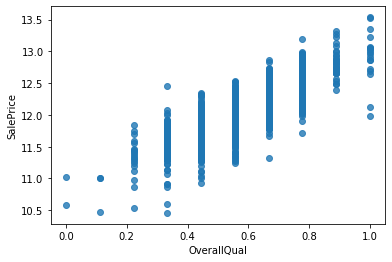

In [68]:
# 觀察重要特徵與目標的分布
# 第一名 : OverallQual              
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x=df['OverallQual'], y=train_Y, fit_reg=False)
plt.show()

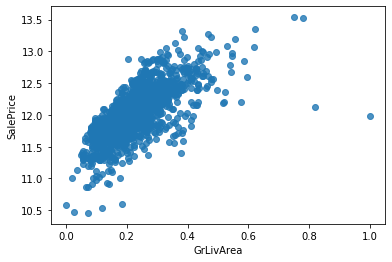

In [69]:
# 第二名 : GrLivArea
sns.regplot(x=df['GrLivArea'], y=train_Y, fit_reg=False)
plt.show()